In [28]:

import pandas as pd
import torch
import numpy as np




In [29]:

tokenize = lambda x : list(x)
vocab = {c : i+2 for i, c in enumerate(list('abcdefghijklmnopqrstuvwxyz'))}
vocab['_'] = 1 # mask
vocab['$'] = 0 # pad
vocab['%'] = len(vocab) # sep

PAD_IDX = vocab['$']

vocab_transform = lambda toks : torch.tensor(np.vectorize(lambda x : vocab[x])(toks) )



In [30]:
TXT_FILENAME = "dictionary.csv"#r"hangman_dict_real.csv"
import re
import numpy as np
import random as rand

def mask_characters(word, num_chars_to_mask=-1, to_mask=False):
        if type(word) == float:
            print(word)
            word = str(word)
        if not to_mask:
            to_mask = rand.random()*0.9
        if num_chars_to_mask == -1:
            num_chars_to_mask = int(max([1, int(to_mask*len(set(word)))]))

        # Ensure num_chars_to_mask is within the valid range
        if num_chars_to_mask < 1 or num_chars_to_mask > len(set(word)):
            raise ValueError("Number of characters to mask is out of range")
        
        # Select unique characters from the word
        unique_chars = list(set(word))
        
        # Randomly choose num_chars_to_mask characters to mask
        chars_to_mask = rand.sample(unique_chars, num_chars_to_mask)
        
        # Create the masked word
        masked_word = ''.join(['_' if char in chars_to_mask else char for char in word])

        cannot_guess = sorted(list(set("abcdefghijklmnop") - (set(word))))
        #        random_guessed_letters = cannot_guess#rand.sample(cannot_guess, min(6, int(rand.random()*len(cannot_guess))+1))

        random_guessed_letters = rand.sample(cannot_guess, min(6, int(rand.random()*len(cannot_guess))+1))

        label = get_label(word, masked_word, to_mask)
        for c in random_guessed_letters:
            label[vocab[c]] = 0#-1
        
        return masked_word + "%" + ''.join(random_guessed_letters), label#get_label(word, masked_word, to_mask)



def get_dictionary_df(txt_filename=TXT_FILENAME):
    return pd.read_csv(filepath_or_buffer=txt_filename, encoding="utf8", names=['words'])
    #print(df.head())
import math
def get_label(word, masked, to_mask=False):
    guessable = set(word) - (set(masked))
    freqs = [0]*len(vocab)

    for c in word:
        freqs[vocab[c]] += 1 + (freqs[vocab[c]]) if c in guessable else 0  # offset by 2 for pad and unk tokens
        # Consider boosting vals where freq > 1 (undo softmax sort of)

    for c in range(len(freqs)):
        if freqs[c] == 0:
            freqs[c] = -torch.inf

    if word == "kirshbaum":
        print("freak: ", freqs)
        print(torch.softmax(torch.tensor(freqs), dim=0)*math.sqrt(1-to_mask)*2)

    return torch.softmax(torch.tensor(freqs), dim=0)*math.sqrt(1-to_mask)*2


def get_dataset_from_df(df):
    df['transformed'] = df['words'].apply(mask_characters)
    df['src'] = df['transformed'].apply(lambda x : x[0])
    df['tgt'] = df['transformed'].apply(lambda x : x[1])

    src, tgt = list(df['src']), list(df['tgt'])
    return src, tgt


class DictionaryDataset(torch.utils.data.Dataset):
    def __init__(self, txt_filename=TXT_FILENAME, truncate=False) -> None:
        # load data + preprocess
        df = get_dictionary_df(txt_filename)[:truncate] if truncate else get_dictionary_df(txt_filename)
        self.src, self.tgt = get_dataset_from_df(df)
        self.src = list(self.src)
        self.tgt = self.tgt

    def __getitem__(self, idx) -> torch.Tensor:
        return self.src[idx], self.tgt[idx]

    def __len__(self):
        return len(self.src)
    
# df = get_dictionary_df(txt_filename=TXT_FILENAME)
# src, tgt = get_dataset_from_df(df)

In [32]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        #pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(1)])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class MaskedLmTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(MaskedLmTransformer, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(d_model=emb_size,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.encoder = TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_encoder_layers)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.src_tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.generator = nn.Linear(emb_size, vocab_size)

    def forward(self, word):
        embedded = self.src_tok_emb(word)
        emb_1 = self.positional_encoding(embedded)

        encoded = self.encoder(emb_1)
        encoded = encoded.mean(1)   
        
        return self.generator(encoded)



In [33]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab)
EMB_SIZE = 26
NHEAD = 2
FFN_HID_DIM = 26
BATCH_SIZE = 128#256#128#512
NUM_ENCODER_LAYERS = 5

transformer = MaskedLmTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    vocab_size=SRC_VOCAB_SIZE,
    dim_feedforward=FFN_HID_DIM,
    dropout= 0.1
)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

#ignore_index=PAD_IDX)


optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
from torch.nn.utils.rnn import pad_sequence


text_transform = lambda x : vocab_transform(tokenize(x))

def impregnate(x, inp):#inds):
    inds = [i for i, x in enumerate(inp) if x != vocab['_']]
    for i in inds:
        x[i] = inp[i]
    return x
    

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample))
        tgt_batch.append((list(tgt_sample)))
        #tgt_batch.append(impregnate(text_transform(tgt_sample), src_transformed))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    #tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(tgt_batch)

#print(text_transform("_buildisdfkklsdfjdsngsgermany")) # Test

In [35]:
# DataLoader
from torch.utils.data import DataLoader
total_data_iter = DictionaryDataset()#truncate=100)
train_size = int(0.8 * len(total_data_iter))
test_size = len(total_data_iter) - train_size
train_iter, test_iter = torch.utils.data.random_split(total_data_iter, [train_size, test_size])

#tst = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

freak:  [-inf, -inf, 1, -inf, -inf, -inf, -inf, -inf, -inf, 1, 1, -inf, 1, -inf, -inf, -inf, -inf, -inf, -inf, 1, -inf, -inf, 1, -inf, -inf, -inf, -inf, -inf, -inf]
tensor([0.0000, 0.0000, 0.1646, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1646, 0.1646, 0.0000, 0.1646, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1646, 0.0000, 0.0000, 0.1646, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
nan


In [50]:
rare_words = ['g', 'z', 'h', 'v'] # Find a better way to do this pls
indices = [vocab[l] for l in rare_words]
mask_out = [vocab['_'], vocab['$'], vocab['%']]
mask = [1 if i in indices else (0 if i in mask_out else 0.5) for i in range(len(vocab))]
print(mask)

loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(mask))

[0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 1, 0]


Let\'s define training and evaluation loop that will be called for each
epoch.


In [51]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)#, dtype=torch.float)

        #print(src.shape)

        optimizer.zero_grad()

        logits = model(src)

        loss = loss_fn(logits, tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses/len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)#, dtype=torch.float)

        logits = model(src)

        loss = loss_fn(logits, tgt)
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [52]:
from timeit import default_timer as timer
NUM_EPOCHS = 10#3#15

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    #val_loss = 3
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))



Epoch: 1, Train loss: 2.060, Val loss: 2.033, Epoch time = 125.692s
Epoch: 2, Train loss: 2.043, Val loss: 2.016, Epoch time = 129.197s
Epoch: 3, Train loss: 2.028, Val loss: 2.000, Epoch time = 128.707s
Epoch: 4, Train loss: 2.014, Val loss: 1.986, Epoch time = 128.867s
Epoch: 5, Train loss: 2.001, Val loss: 1.971, Epoch time = 122.155s
Epoch: 6, Train loss: 1.987, Val loss: 1.958, Epoch time = 127.009s
Epoch: 7, Train loss: 1.975, Val loss: 1.945, Epoch time = 130.880s
Epoch: 8, Train loss: 1.964, Val loss: 1.933, Epoch time = 135.902s
Epoch: 9, Train loss: 1.953, Val loss: 1.921, Epoch time = 125.770s
Epoch: 10, Train loss: 1.943, Val loss: 1.912, Epoch time = 134.716s


In [59]:
torch.save(transformer, f="taco")

In [38]:
# For word probs

text = "_i___a__" # kirshbaum 3 4
# probs, max = get_probs(text, transformer=transformer)
liks = get_liks(text, transformer=transformer)
probs = torch.softmax(liks, dim=0)
print(torch.max(probs, dim=0))

reverse_voca_lookup = {vocab[k]:k for k in vocab}
pairs = {reverse_voca_lookup[i]:liks[i] for i in range(len(liks))}#, key=lambda x : 
pairs = dict(sorted(pairs.items(), key=lambda item: item[1], reverse=True))
               
print(pairs)

NameError: name 'get_liks' is not defined

In [53]:


def get_liks(word, transformer):
    prediction = transformer(torch.tensor([list(text_transform(word))]))
    return prediction[0]

def guess_letter(masked, excluded, transformer):
    liks = get_liks(masked, transformer=transformer)
    reverse_voca_lookup = {vocab[k]:k for k in vocab}
    pairs = {reverse_voca_lookup[i]:liks[i] for i in range(len(liks))}
    for c in excluded:
        pairs.pop(c)
    pairs = sorted(pairs.items(), key=lambda item: item[1], reverse=True)
    lets = [p[0] for p in pairs]
    return lets[0], lets, pairs
    


In [54]:
def play_game(model, word, add_wrongs=True):
    if type(model) == str:
        model = torch.load(model,  map_location=torch.device('cpu'))
    masked = '_'*len(word)

    wrongs = 0
    guessed = set()
    wrong_guesses = set()

    while(wrongs < 6):
        in_word = set(masked)# - {'_'}
        guess, _, _ = guess_letter(masked, excluded=guessed.union(in_word), transformer=model)
        masked = ''.join([word[i] if word[i] == guess else masked[i] for i in range(len(word))]) + ("%" + ''.join(sorted(list(wrong_guesses))) if add_wrongs else "")
        print(guess, masked)

        guessed.add(guess)
        if guess not in set(word):
            wrongs+=1
            wrong_guesses.add(guess)

        end_index = masked.find("%") if add_wrongs else len(masked)
        if masked[0:end_index]==word:
            print("done")
            print(wrongs, " wrong guesses")
            break


In [55]:
import torch
def play_game(model, word, add_wrongs=True):
    if type(model) == str:
        model = torch.load(model,  map_location=torch.device('cpu'))
    masked = '_'*len(word)

    wrongs = 0
    guessed = set()
    wrong_guesses = set()

    while(wrongs < 6):
        in_word = set(masked)# - {'_'}
        guess, _, _ = guess_letter(masked, excluded=guessed.union(in_word), transformer=model)
        masked = ''.join([word[i] if word[i] == guess else masked[i] for i in range(len(word))]) + ("%" + ''.join(sorted(list(wrong_guesses))) if add_wrongs else "")
        print(guess, masked)

        guessed.add(guess)
        if guess not in set(word):
            wrongs+=1
            wrong_guesses.add(guess)

        end_index = masked.find("%") if add_wrongs else len(masked)
        if masked[0:end_index]==word:
            print("done")
            print(wrongs, " wrong guesses")
            
            return 1
    return 1-(float(masked.count('_'))/len(word))


In [56]:
#play_game("ff", "lacerations")
play_game("haerin", "zebra", add_wrongs=True)
print()
play_game("jisoo", "zebra", add_wrongs=True)
print()
play_game("rose_with_implants", "zebra", add_wrongs=True)
print()
play_game(transformer, "something", add_wrongs=True)



#torch.save(transformer, "haerin")

n _____%
l _____%n
i _____%ln
a ____a%iln
r ___ra%iln
e _e_ra%iln
d _e_ra%iln
$ _e_ra%diln
m _e_ra%$diln

n _____%
l _____%n
a ____a%ln
r ___ra%ln
$ ___ra%ln
e _e_ra%$ln
s _e_ra%$ln
p _e_ra%$lns
d _e_ra%$lnps

e _e___%
r _e_r_%
d _e_r_%
l _e_r_%d
a _e_ra%dl
t _e_ra%dl
c _e_ra%dlt
i _e_ra%cdlt
s _e_ra%cdilt

n _______n_%
o _o_____n_%
e _o_e___n_%
a _o_e___n_%
l _o_e___n_%a
t _o_et__n_%al
i _o_et_in_%al
s so_et_in_%al
r so_et_in_%al
u so_et_in_%alr
c so_et_in_%alru
p so_et_in_%aclru


0.6666666666666667

In [57]:
import os
from collections import defaultdict 

def train_loop(dir = "model_stock", words=["something", "monkey", "lacerations"]):
  #print("d")
  results = defaultdict(list)#{}

  for f in os.listdir(dir):
    model = torch.load(f"{dir}/{f}", map_location=torch.device('cpu'))
    for word in words:
      with_wrongs = play_game(model, word, add_wrongs=True)
      no_wrongs = play_game(model, word, add_wrongs=False)
      
      results[f+"-wrongs_added"].append((float(len(word)), with_wrongs))
      results[f+"-no_wrongs"].append((float(len(word)), with_wrongs))

    #print("dd")
  return results

results = train_loop()

i ______i__%
l ______i__%
t ____t_i__%l
e ___et_i__%l
o _o_et_i__%l
a _o_et_i__%l
u _o_et_i__%al
n _o_et_in_%alu
s so_et_in_%alu
d so_et_in_%alu
p so_et_in_%adlu
c so_et_in_%adlpu
e ___e_____
i ___e__i__
o _o_e__i__
a _o_e__i__
l _o_e__i__
n _o_e__in_
r _o_e__in_
d _o_e__in_
t _o_et_in_
u _o_et_in_
c _o_et_in_
e ____e_%
a ____e_%
l ____e_%a
o _o__e_%al
t _o__e_%al
d _o__e_%alt
n _on_e_%adlt
i _on_e_%adlt
u _on_e_%adilt
i ______
o _o____
l _o____
n _on___
e _on_e_
r _on_e_
a _on_e_
t _on_e_
d _on_e_
i _______i___%
e ___e___i___%
o ___e___io__%
l l__e___io__%
t l__e__tio__%
a la_e_atio__%
c lace_atio__%
u lace_atio__%
r laceratio__%u
p laceratio__%u
n laceration_%pu
s lacerations%pu
done
2  wrong guesses
e ___e_______
i ___e___i___
l l__e___i___
o l__e___io__
r l__er__io__
n l__er__ion_
a la_era_ion_
t la_eration_
u la_eration_
s la_erations
c lacerations
done
1  wrong guesses
e ___e_____%
i ___e__i__%
n ___e__in_%
l ___e__in_%
r ___e__in_%l
o _o_e__in_%lr
t _o_et_in_%lr
c _o_et_in_%lr
s

momo (with implants)-wrongs_added [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 1)]
momo (with implants)-no_wrongs [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 1)]
chaewon (with implants)-wrongs_added [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 1)]
chaewon (with implants)-no_wrongs [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 1)]
jenny-wrongs_added [(9.0, 0.6666666666666667), (6.0, 0.33333333333333337), (11.0, 0.9090909090909091)]
jenny-no_wrongs [(9.0, 0.6666666666666667), (6.0, 0.33333333333333337), (11.0, 0.9090909090909091)]
jisoo-wrongs_added [(9.0, 0.5555555555555556), (6.0, 0.5), (11.0, 0.9090909090909091)]
jisoo-no_wrongs [(9.0, 0.5555555555555556), (6.0, 0.5), (11.0, 0.9090909090909091)]
haerin-wrongs_added [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 0.7272727272727273)]
haerin-no_wrongs [(9.0, 0.6666666666666667), (6.0, 0.5), (11.0, 0.7272727272727273)]
rose-wrongs_added [(9.0, 0.7777777777777778), (6.0, 0.5), (11.0, 0.9090909090909091)]
rose-no_wrongs [(9.0, 0.777

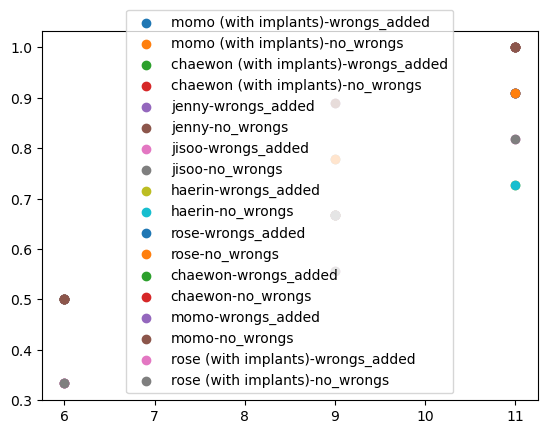

In [58]:
import matplotlib.pyplot as plt
#!pip install PyQt6
# from PyQt6.QtCore import *
# from PyQt6.QtGui import *
# from PyQt6.QtWidgets import *
# import PyQt6
#%matplotlib qt 
legend = []
for k, v in results.items():
  #plt.plot(v[0], v[1])
  print(k, v)
  # print(*zip(*v))
  plt.scatter(*zip(*v), )
  legend.append(k)

plt.legend(legend)